In [40]:
import os
import time

from tqdm import tqdm
import numpy as np
import wandb
from matplotlib import pyplot as plt
import torch
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader
from torchvision import transforms

from my_utils import data, models
from my_utils.utils import Hook, load_model, load_cam_model, get_conv_weights, get_feature_maps, get_gradients, get_avg_embeds, check_accuracy

from SimMask import MySimCAM, MyGradCAM, MyCAM4fmap
from SimMask.vis import vis_4D_plot


# life save magic code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
print(f"torch version: {torch.__version__}")
use_cuda = torch.cuda.is_available()
if use_cuda:
    GPU_nums = torch.cuda.device_count()
    GPU = torch.cuda.get_device_properties(0)
    print(f"There are {GPU_nums} GPUs in total.\nThe first GPU is: {GPU}")
    if '3060' in GPU.name:
        print(f"CUDA version: {torch.cuda_version}")
    else:
        print(f"CUDA version: {torch.version.cuda}")
device = torch.device(f"cuda:1" if use_cuda else "cpu")
print(f"Using {device} now!")

torch version: 1.10.2+cu113
There are 8 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='Tesla V100-SXM2-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)
CUDA version: 11.3
Using cuda:1 now!


In [5]:
Dataset_DIR = f'/home/wangyh/01-Projects/03-my/Datasets/polygons_unfilled_64_3'
T = transforms.Compose([
    transforms.ToTensor()
])
vis_data = data.MyDataset(os.path.join(Dataset_DIR, 'vis'), transform=T)
vis_loader = DataLoader(vis_data, batch_size=len(vis_data))

In [6]:
imgs, labels = next(iter(vis_loader))
print(imgs.shape)
print(labels)

torch.Size([8, 1, 64, 64])
tensor([0, 0, 1, 1, 2, 2, 3, 3])


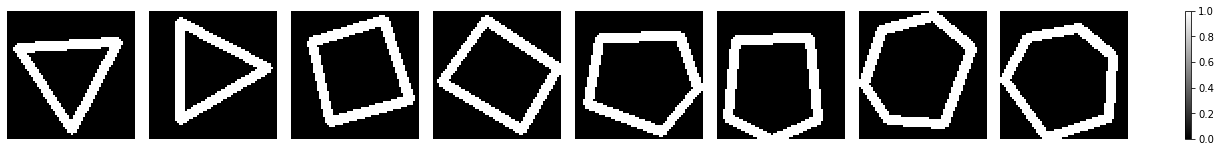

In [7]:
fig = vis_4D_plot(data=imgs.permute(1, 0, 2, 3), figsize_factor=2, cmap='gray', return_mode='plt_fig', tune_factor=1)

In [80]:
ckpt_name = 'best'
cam_model = load_cam_model(run_name='2022_06_06_08_33_24',
                           log_root='/home/wangyh/01-Projects/03-my/my_final_1',
                           ckpt_name=ckpt_name).to(device)

Loading model parameters ...
best val acc is: 0.9232500195503235
Successfully load model parameters!


In [81]:
my_cam = MyCAM4fmap(model=cam_model, inputs=imgs, target_classes=labels)

In [30]:
cams = my_cam(layer_index=3)
cams.shape

(8, 64, 64)

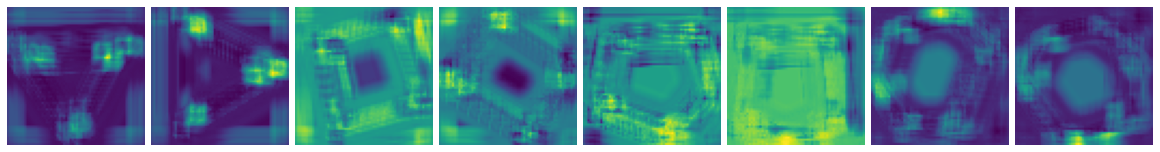

In [76]:
cam_fig = vis_4D_plot(data=cams[None, :], figsize_factor=2, cmap='viridis', return_mode='plt_fig', norm=False)

In [77]:
cam_fig.savefig(f'/home/wangyh/01-Projects/03-my/figures/Sim-Mask/cam.png', bbox_inches='tight')

In [32]:
grad_cams = my_cam(layer_index=3)
grad_cams.shape

(8, 64, 64)

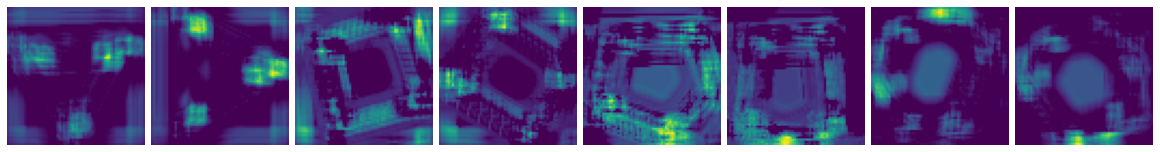

In [74]:
grad_cam_fig = vis_4D_plot(data=grad_cams[None, :], figsize_factor=2, cmap='viridis', return_mode='plt_fig', norm=False)

In [78]:
grad_cam_fig.savefig(f'/home/wangyh/01-Projects/03-my/figures/Sim-Mask/grad_cam.png', bbox_inches='tight')

In [71]:
my_cams = my_cam(layer_index=3)

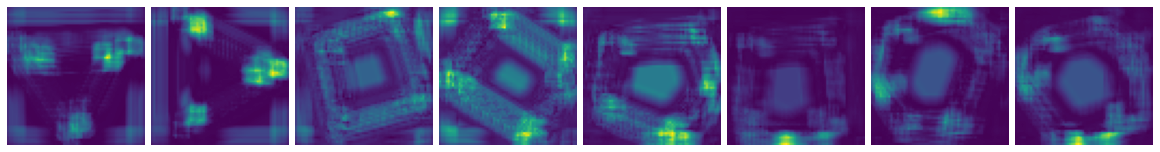

In [73]:
my_cam_fig = vis_4D_plot(data=my_cams[None, :], figsize_factor=2, cmap='viridis', return_mode='plt_fig', norm=False)

In [79]:
my_cam_fig.savefig(f'/home/wangyh/01-Projects/03-my/figures/Sim-Mask/my_cam.png', bbox_inches='tight')

In [47]:
my_cam.compose_weights.squeeze()

array([[0.05886934, 0.03970002, 0.10392216, 0.609339  , 0.5511533 ,
        0.5703282 , 0.2342053 , 0.0088928 ],
       [0.08525047, 0.05050351, 0.14115137, 0.6916654 , 0.63597906,
        0.6585447 , 0.24653718, 0.00717465],
       [0.20325378, 0.14567527, 0.2951822 , 0.23071043, 0.17695275,
        0.20000052, 0.37466085, 0.04444065],
       [0.23363513, 0.15488559, 0.3395291 , 0.23310113, 0.20649192,
        0.2241121 , 0.2371583 , 0.02898171],
       [0.38248092, 0.2965274 , 0.4664758 , 0.10646865, 0.0743594 ,
        0.08736536, 0.28601187, 0.12230233],
       [0.5209511 , 0.4413248 , 0.5344943 , 0.10229255, 0.07508785,
        0.08775587, 0.244829  , 0.23206487],
       [0.6704577 , 0.54929996, 0.7190535 , 0.04707186, 0.03116458,
        0.03794483, 0.21254006, 0.24350658],
       [0.60018104, 0.5017828 , 0.61025405, 0.05673805, 0.03966063,
        0.04686132, 0.23740667, 0.25190789]], dtype=float32)

In [106]:
my_gmp_cams = my_cam(layer_index=3)

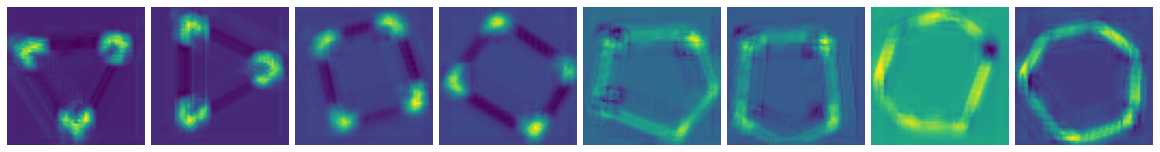

In [107]:
my_gmp_cam_fig = vis_4D_plot(data=my_gmp_cams[None, :], figsize_factor=2, cmap='viridis', return_mode='plt_fig', norm=False)

In [108]:
my_gmp_cam_fig.savefig(f'/home/wangyh/01-Projects/03-my/figures/Sim-Mask/gmp_cam.png', bbox_inches='tight')